# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [2]:
%%capture
import sys

In [66]:
# TODO: Install any packages that you might need
# !{sys.executable} -m pip install tensorflow Pillow argparse numpy boto3 sagemaker smdebug 
!{sys.executable} -m pip install smdebug torch torchvision tqdm boto3 

In [67]:
# TODO: Import any packages that you might need
import os
import json
import boto3
from tqdm import tqdm
import sagemaker
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs,ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from PIL import Image
import io
from IPython import display
import matplotlib.pyplot as plt
from sagemaker.tensorflow import TensorFlow
from sagemaker.debugger import Rule, rule_configs
import smdebug
from smdebug.core.modes import ModeKeys
from sagemaker.predictor import Predictor
from smdebug.trials import create_trial
from sagemaker.pytorch import PyTorch




## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [ ]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Class 4 has 2373 samples.
Class 2 has 2299 samples.
Class 1 has 1228 samples.
Class 5 has 1875 samples.
Class 3 has 2666 samples.
Total samples in dataset: 10441
Percentage of samples in class 4: 22.73%
Percentage of samples in class 2: 22.02%
Percentage of samples in class 1: 11.76%
Percentage of samples in class 5: 17.96%
Percentage of samples in class 3: 25.53%


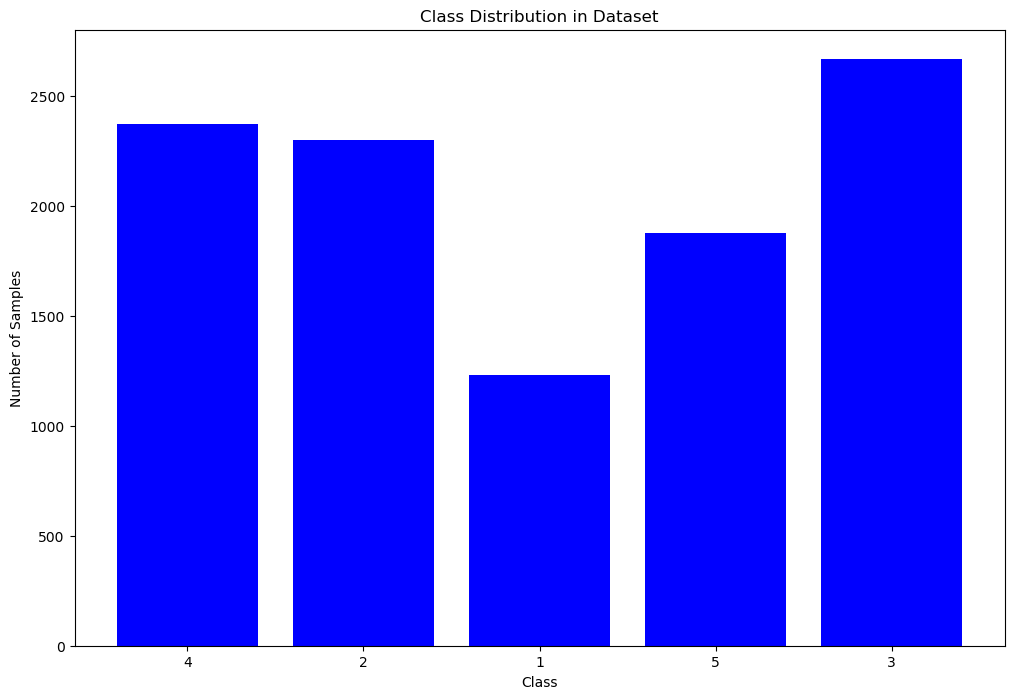

In [90]:


def analyze_dataset(root_folder='train_data'):
    classes = [folder for folder in os.listdir(root_folder)]
    class_counts = {}

    for class_ in classes:
        class_folder = os.path.join(root_folder, class_)
        num_samples = len(os.listdir(class_folder))
        class_counts[class_] = num_samples
        print(f"Class {class_} has {num_samples} samples.")

    total_samples = sum(class_counts.values())
    print(f"Total samples in dataset: {total_samples}")

    for class_, num_samples in class_counts.items():
        print(f"Percentage of samples in class {class_}: {num_samples / total_samples * 100:.2f}%")

    # Bar graph
    plt.figure(figsize=(12,8))  # Set figure size
    plt.bar(class_counts.keys(), class_counts.values(), color='b')  # Create bar graph
    plt.xlabel('Class')  # Set x label
    plt.ylabel('Number of Samples')  # Set y label
    plt.title('Class Distribution in Dataset')  # Set title
    plt.show()  # Show the graph

analyze_dataset()

In [6]:
import random
import shutil
import numpy as np


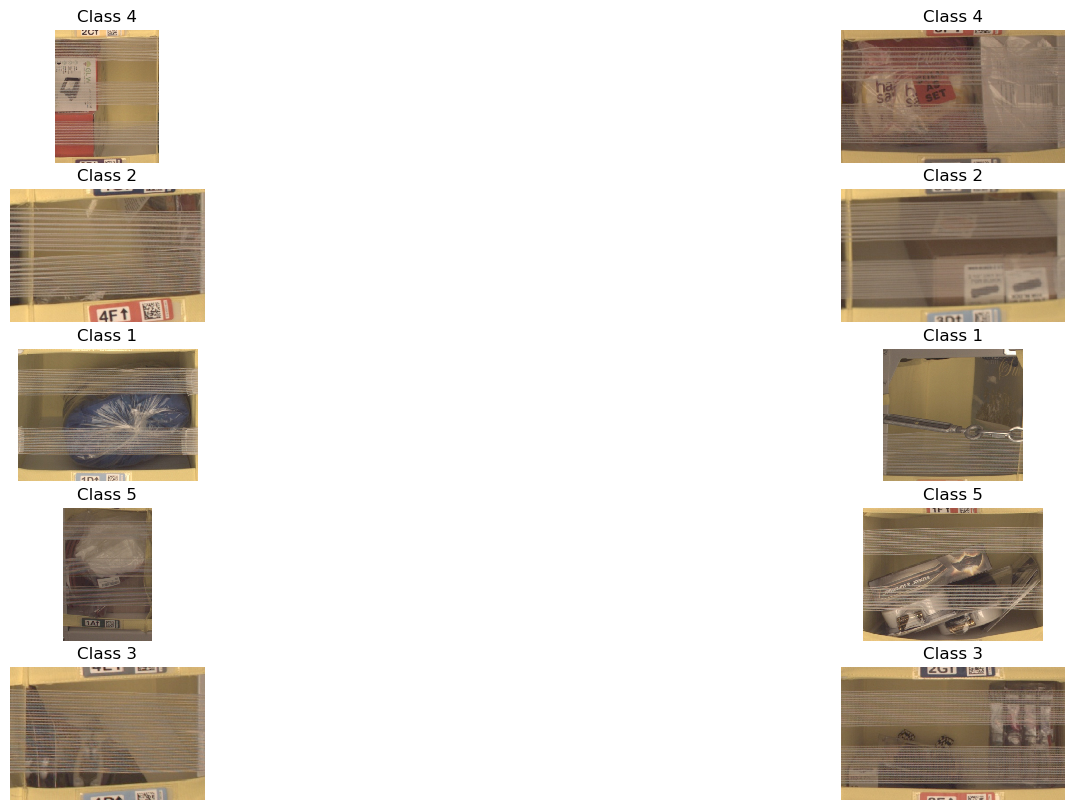

In [7]:

def display_random_images(root_folder='train_data', num_images=2):
    classes = [folder for folder in os.listdir(root_folder)]
    
    fig = plt.figure(figsize=(20, 10))

    for i, class_ in enumerate(classes):
        class_folder = os.path.join(root_folder, class_)
        image_files = os.listdir(class_folder)
        random_images = random.sample(image_files, num_images)

        for j, image_file in enumerate(random_images):
            image_path = os.path.join(class_folder, image_file)
            image = Image.open(image_path)

            ax = fig.add_subplot(len(classes), num_images, i * num_images + j + 1)
            ax.imshow(image)
            ax.set_title(f"Class {class_}")
            ax.axis('off')

    plt.show()

display_random_images()

In [ ]:
def create_data_splits(source_folder='train_data', target_folder='binDataset', train_size=0.7, valid_size=0.15):
    # Ensure the target directory exists
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    classes = [folder for folder in os.listdir(source_folder)]
    for class_ in classes:
        print(f"Processing class: {class_}")

        # Create target subdirectories
        os.makedirs(os.path.join(target_folder, 'train', class_), exist_ok=True)
        os.makedirs(os.path.join(target_folder, 'valid', class_), exist_ok=True)
        os.makedirs(os.path.join(target_folder, 'test', class_), exist_ok=True)

        # List all images in this class
        image_files = os.listdir(os.path.join(source_folder, class_))

        # Shuffle and split data
        np.random.shuffle(image_files)
        train, valid, test = np.split(image_files, [int(train_size*len(image_files)), int((train_size+valid_size)*len(image_files))])

        # Copy files into respective splits
        for image_file in train:
            shutil.copy(os.path.join(source_folder, class_, image_file), os.path.join(target_folder, 'train', class_, image_file))
        for image_file in valid:
            shutil.copy(os.path.join(source_folder, class_, image_file), os.path.join(target_folder, 'valid', class_, image_file))
        for image_file in test:
            shutil.copy(os.path.join(source_folder, class_, image_file), os.path.join(target_folder, 'test', class_, image_file))

create_data_splits()

In [ ]:
#TODO: Upload the data to AWS S3
s3_bucket = 'ml-data-udacity-learning/'
!aws s3 cp --recursive binDataset s3://$s3_bucket/binDataset


## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [8]:
#TODO: Declare your model training hyperparameter.
hyper_param= {
    'batch_size': '64',
    'learning_rate': '0.001',
    'epochs': '1'
}

In [9]:
session = sagemaker.Session()
bucket = session.default_bucket()

In [10]:
os.environ['SM_MODEL_DIR'] = 's3://'+bucket+'/model/'
os.environ['SM_CHANNEL_TRAIN']= "s3://ml-data-udacity-learning//binDataset/"


In [11]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000,
    framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10",
                    "eval.save_interval": "10"}
)


Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [68]:
#TODO: Create your training estimator
estimator = PyTorch(
    entry_point='train.py',
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    framework_version='1.4.0', 
    py_version='py3',
    hyperparameters=hyper_param,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [69]:
# TODO: Fit your estimator
estimator.fit({"train":  "s3://ml-data-udacity-learning//binDataset/"}, wait=True)


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-07-11-23-41-51-816


Using provided s3_resource
2023-07-11 23:41:52 Starting - Starting the training job...
2023-07-11 23:42:21 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-07-11 23:43:21 Downloading - Downloading input data......
2023-07-11 23:44:22 Training - Downloading the training image...
2023-07-11 23:44:53 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-11 23:45:06,932 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2023-07-11 23:45:06,962 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-11 23:45:06,964 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-07-11 23:45:07,130 sagemaker-containers INFO     

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [ ]:
# TODO: Display the profiler output
debugging_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
debugging_path

In [ ]:
! aws s3 ls {debugging_path} --recursive


In [ ]:
! aws s3 cp {debugging_path} ./ --recursive


In [ ]:
from IPython.display import display, HTML


In [ ]:
# Open and read the file
with open('./ProfilerReport/profiler-output/profiler-report.html', 'r') as f:
    html_string = f.read()

# Display the HTML string in the notebook
display(HTML(html_string))

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [71]:
from sagemaker.tensorflow import TensorFlowModel
from sagemaker.pytorch import PyTorchModel


In [72]:
estimator.model_data

's3://sagemaker-ap-southeast-2-429448266923/pytorch-training-2023-07-11-23-41-51-816/output/model.tar.gz'

In [44]:
                        role=sagemaker.get_execution_role(), 
print(role)

('arn:aws:iam::429448266923:role/service-role/AmazonSageMaker-ExecutionRole-20230507T001289',)


In [77]:
# TODO: Deploy your model to an endpoint
model = PyTorchModel(model_data=estimator.model_data,
                     role=sagemaker.get_execution_role(), 
                     framework_version='1.8.0',
                     entry_point='inference.py',
                     py_version='py3',
                     sagemaker_session=session)





In [79]:
# TODO: Run an prediction on the endpoint
predictor = model.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

INFO:sagemaker:Repacking model artifact (s3://sagemaker-ap-southeast-2-429448266923/pytorch-training-2023-07-11-23-41-51-816/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-ap-southeast-2-429448266923/pytorch-inference-2023-07-12-00-54-46-549/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-07-12-00-56-43-078
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-07-12-00-56-43-807
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-07-12-00-56-43-807


---------!

In [75]:
import base64
from sagemaker.serializers import NumpySerializer
from sagemaker.deserializers import NumpyDeserializer



In [84]:
print(predictor)


PyTorchPredictor: {'endpoint_name': 'pytorch-inference-2023-07-12-00-56-43-807', 'sagemaker_session': <sagemaker.session.Session object at 0x7f5292c60890>, 'deserializer': <sagemaker.base_deserializers.NumpyDeserializer object at 0x7f5290066d50>}


In [85]:
predictor.serializer = sagemaker.serializers.IdentitySerializer('application/x-image')


In [88]:
# Open the image and convert it to bytes
image_path = './binDataset/test/1/00048.jpg'
with open(image_path, 'rb') as f:
    image_bytes = f.read()

# Make the prediction
output = predictor.predict(data=image_bytes, initial_args={'ContentType': 'application/x-image'})

# Print the prediction
print('The predicted class is: ', output)




The predicted class is:  1


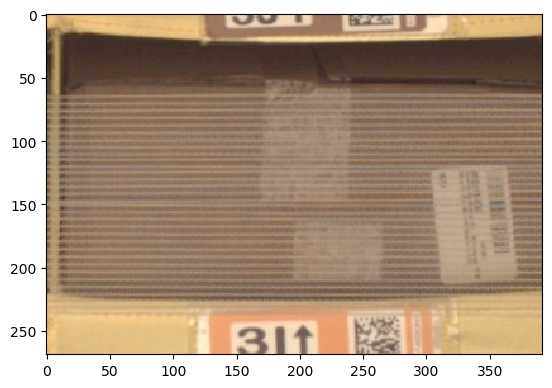

In [89]:

# Display the image
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()